## Imports

In [1]:
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint, EarlyStopping, LRScheduler

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt

import numpy as np

import os
import sys

sys.path.append(os.path.abspath('..'))

from src.models.TurbulenceNetwork import TurbulenceNetwork
from src.data_gens.TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from src.utils.plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from src.utils.model_utils import *
from src.utils.data_utils import *


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Device: ", device)

%load_ext autoreload
%autoreload 2


Device:  cuda:0


## Misc Utilities

In [2]:
class MAPELoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super(MAPELoss, self).__init__()
        self.eta = 1e-9

    def forward(self, y_pred, y_true):
        l = torch.abs((y_true - y_pred)) / (torch.abs(y_true) + self.eta)

        return torch.mean(l)

class RMSELoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super(RMSELoss, self).__init__()
        self.eta = 1e-8

    def forward(self, y_pred, y_true):
        l = torch.sqrt(torch.mean(torch.pow((y_true - y_pred), 2)))

        return l


## Data Generation

/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:89: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


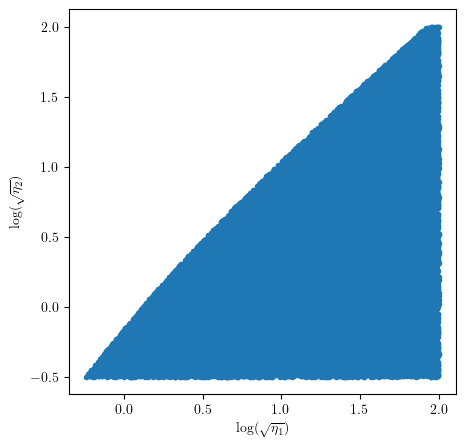

In [13]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 2.0)

# Defining whether to exclude certain areas of the data
exclude_area = True
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = np.array([-0.5, 0.0])
eta_2_range = np.array([-.5, 0.0])

etas_train, gs_train = generate_log_data(SSG_gen, log, 80_000, shuffle=True, gen_type="d_condition", d_condition="<=", eta_1_range=eta_1_range, eta_2_range=eta_2_range)

etas_test, gs_test = generate_log_data(SSG_gen, log, 10_000, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    plot_data_generation_diff(etas_train)


In [14]:
from sklearn.preprocessing import StandardScaler

x_scaler = CustomScalerX().fit(etas_train)
y_scaler = StandardScaler().fit(gs_train)

x_scaled_train = x_scaler.transform(etas_train)
y_scaled_train = y_scaler.transform(gs_train)

x_train = torch.tensor(x_scaled_train, dtype=torch.float32)
y_train = torch.tensor(y_scaled_train, dtype=torch.float32)

x_test = torch.tensor(x_scaler.transform(etas_test), dtype=torch.float32)
y_test = torch.tensor(y_scaler.transform(gs_test), dtype=torch.float32)

## Network Training

In [15]:
# Defining model parameters
chkpt_prefix = 'D_LT_0'
chkpt_dir = '../Model_Checkpoints/Ensemble/' + chkpt_prefix + '/'


net_params = {
        "input_dim": 2,
        "output_dim": 3,
        "num_layers": 4,
        "h_dim": 20,
}

train_params = {
        "criterion": nn.MSELoss,
        "optimizer": torch.optim.Adam,
        "optimizer__weight_decay": 1e-6,
        "lr": 0.001,
        "batch_size": 64,
        "max_epochs": 500,
        "device": device,
        "iterator_train__shuffle": True,
        "iterator_train__num_workers": 4,
        "iterator_train__pin_memory": True,
        "iterator_valid__shuffle": False,
        "iterator_valid__num_workers": 4,
        "iterator_valid__pin_memory": True,
        "verbose": 0,
}

num_members = 40

In [16]:
test_criteria = RMSELoss()

for i in range(num_members):
    net_name = chkpt_prefix + f'_Ens_{i}.pt'

    callbacks = [EarlyStopping(patience=15, threshold=0.000001, threshold_mode='abs', monitor='valid_loss', lower_is_better=True),
        Checkpoint(monitor='valid_loss_best', f_params=net_name, dirname=chkpt_dir),
        LRScheduler(policy=ReduceLROnPlateau, monitor='valid_loss', factor=0.5, patience=5, threshold=0.000001, threshold_mode='abs', mode='min', verbose=True)
    ]
    train_params['callbacks'] = callbacks

    net = create_skorch_model(TurbulenceNetwork, NeuralNetRegressor, net_params, train_params)
    net = net.fit(x_train, y_train)

    net.load_params(f_params=chkpt_dir+net_name)
    with torch.no_grad():
        test_pred = net.predict(x_test)
    print(f"\t\tTest loss: {test_criteria(test_pred, y_test)}")

/home/codygrogan/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


		Test loss: 0.7840372323989868
		Test loss: 1.1964975595474243
		Test loss: 0.9945352077484131
		Test loss: 1.5606329441070557
		Test loss: 1.5150340795516968
		Test loss: 2.343620538711548
		Test loss: 1.3457621335983276
		Test loss: 0.8874189853668213
		Test loss: 1.0547975301742554
		Test loss: 0.9661936163902283
		Test loss: 1.3333178758621216
		Test loss: 1.1465197801589966
		Test loss: 0.805016815662384
		Test loss: 0.7514768838882446
		Test loss: 0.9266396760940552
		Test loss: 0.6682520508766174
		Test loss: 1.2172298431396484
		Test loss: 0.5819981694221497
		Test loss: 0.6359131336212158
		Test loss: 1.0492998361587524
		Test loss: 1.04701566696167
		Test loss: 1.2902895212173462
		Test loss: 0.8428319096565247
		Test loss: 1.7111845016479492
		Test loss: 0.648294985294342
		Test loss: 0.9272677302360535
		Test loss: 1.325812816619873
		Test loss: 0.9001388549804688
		Test loss: 1.0194127559661865
		Test loss: 2.118921995162964
		Test loss: 2.5506744384765625
		Test loss: 1.

## Creating Ensemble

In [17]:
chkpt_prefix = 'D_LT_0'
chkpt_dir = '../Model_Checkpoints/Ensemble/' + chkpt_prefix + '/'
ensemble = []

for i in range(num_members):
    net = reinitialize_model(chkpt_prefix + f'_Ens_{i}.pt', chkpt_dir, TurbulenceNetwork, NeuralNetRegressor, net_params, train_params)
    ensemble.append(net)

test_criteria = nn.MSELoss()
mse_list = np.zeros(num_members)
for i, net in enumerate(ensemble):
    pred = net.predict(x_test)
    mse = test_criteria(torch.tensor(pred, device=device), y_test.to(device=device))
    mse_list[i] = mse.item()

weights = np.exp(-mse_list) / np.sum(np.exp(-mse_list))

print("MSE List: ", mse_list)
print("Weights: ", weights)
print("Sum of Weights: ", weights.sum())

MSE List:  [0.61471444 1.43160641 0.98910034 2.43557501 2.29532814 5.49255753
 1.81107581 0.78751242 1.1125977  0.93353009 1.77773666 1.3145076
 0.64805204 0.56471747 0.85866112 0.44656077 1.48164856 0.33872187
 0.40438548 1.10103023 1.09624171 1.66484702 0.71036571 2.92815256
 0.42028639 0.85982537 1.7577796  0.81024998 1.03920221 4.48983049
 6.50593948 2.13780975 0.52116114 1.04029799 1.77078271 1.87680852
 3.75183535 1.31499636 0.80632359 0.75132632]
Weights:  [0.04176815 0.01845328 0.02872443 0.00676169 0.00777972 0.000318
 0.01262618 0.03513986 0.02538734 0.03036584 0.01305422 0.02074574
 0.04039865 0.04390951 0.03272657 0.04941666 0.01755256 0.05504366
 0.0515454  0.02568272 0.02580599 0.01461431 0.03795809 0.00413173
 0.05073226 0.03268849 0.01331737 0.03434988 0.02732074 0.00086677
 0.00011543 0.00910696 0.04586431 0.02729082 0.01314532 0.01182292
 0.00181305 0.0207356  0.03448502 0.03643472]
Sum of Weights:  1.0


## Generating Statistics Data

0.0011613861632426205
0.0017149457826526981


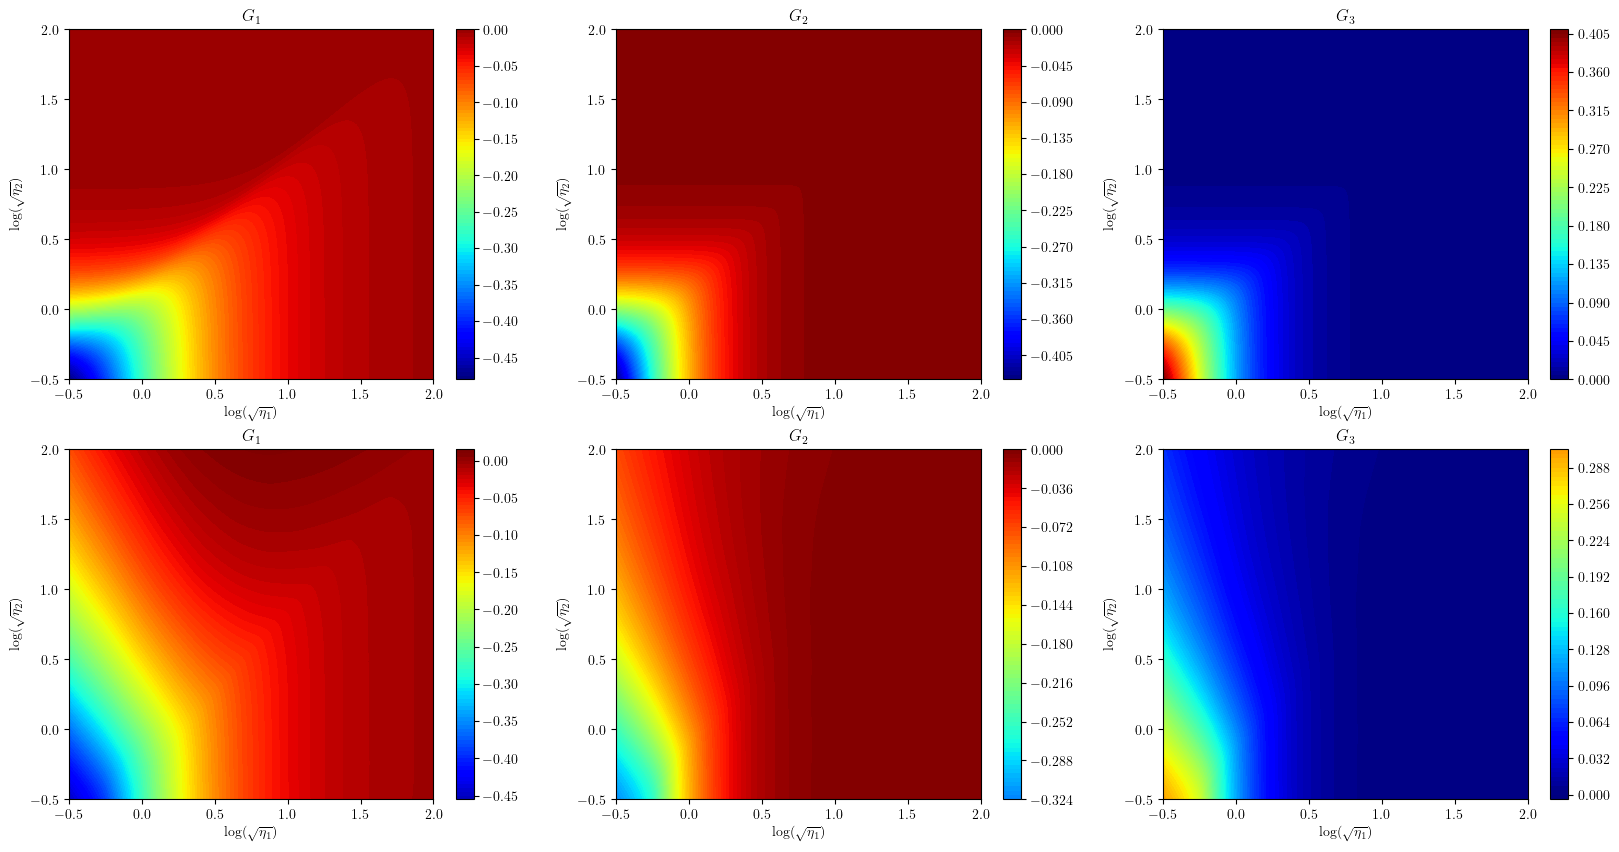

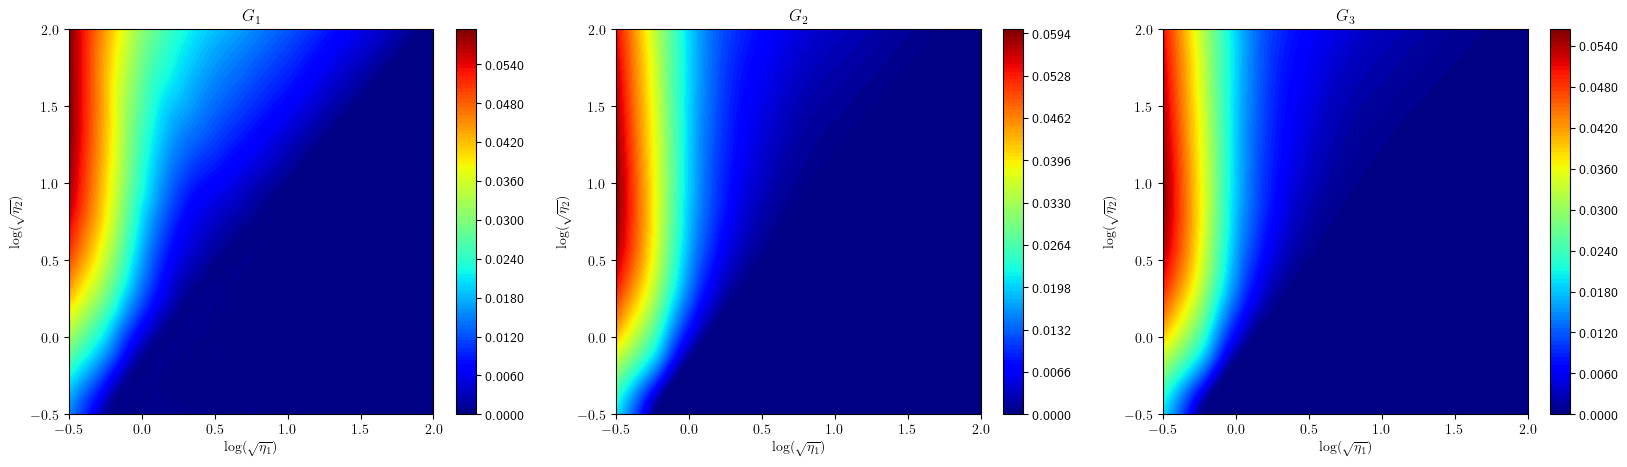

In [18]:
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)
target = G_s.T.reshape(3, dim, dim)

etas = x_scaler.transform(etas)

preds = np.zeros((num_members, len(etas), 3))

for i in range(num_members):
    pred = ensemble[i].predict(etas.astype(np.float32))
    preds[i] = y_scaler.inverse_transform(pred)


pred_test = np.tensordot(weights.reshape(1,-1), preds, axes=(1, 0)).squeeze()
pred = preds.mean(axis=0)

std = preds.std(axis=0)

np.savetxt('../data/Ensemble/' + chkpt_prefix + '_Pred_Mean.csv', pred, delimiter=',')
np.savetxt('../data/Ensemble/' + chkpt_prefix + '_Pred_Std.csv', std, delimiter=',')

rmse_test = test_criteria(torch.tensor(target), torch.tensor(pred_test).T.reshape(3, dim, dim)).item()
rmse = test_criteria(torch.tensor(target), torch.tensor(pred).T.reshape(3, dim, dim)).item()

print(rmse_test)
print(rmse)


plot_heat_map_compare(x_grid, y_grid, target, pred.T.reshape(3, dim, dim), 'Algebraic', 'Ensemble', sup_title=False)

plot_heat_map_3D(x_grid, y_grid, std.T.reshape(3, dim, dim), "Ensemble Standard Deviation", sup_title=False)

## Reload Runs

0.02232117474062385


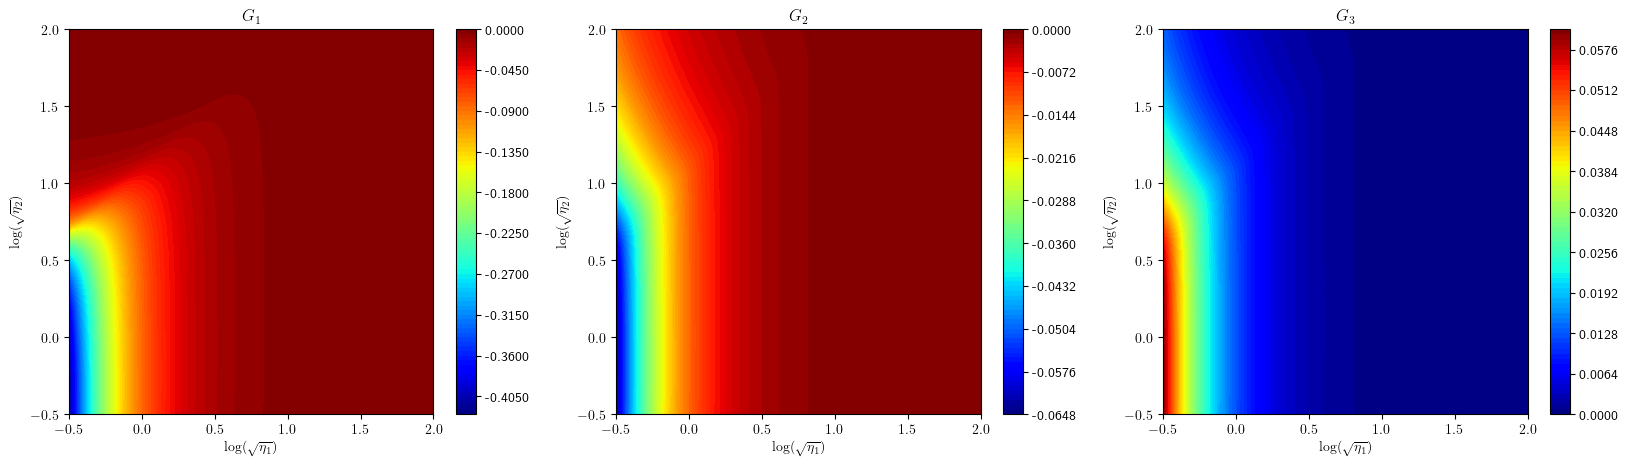

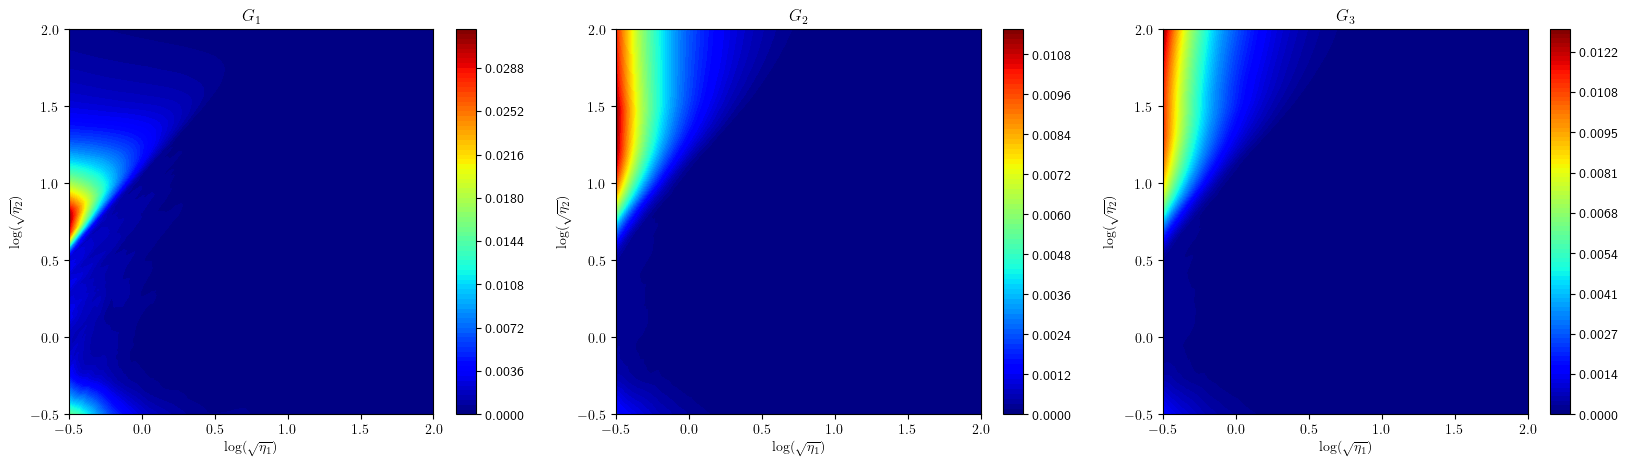

In [26]:
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)

pred = np.loadtxt('../data/Ensemble/D_LT_0_Pred_Mean.csv', delimiter=',')
std = np.loadtxt('../data/Ensemble/D_LT_0_Pred_Std.csv', delimiter=',')

print(np.mean(np.abs(G_s - pred)))

plot_heat_map_3D(x_grid, y_grid, pred.T.reshape(3, dim, dim))
plot_heat_map_3D(x_grid, y_grid, std.T.reshape(3, dim, dim))

## Visualizing Functions

In [17]:
predictions = []
for member in ensemble:
    predictions.append(y_scaler.inverse_transform(member.predict(x_vis)).reshape(1,-1))

predictions.append(y_scaler.inverse_transform(y_vis.cpu().numpy()).reshape(1,-1))

vis_outputs = np.concatenate(predictions, axis=0)

Calculating PHATE...
  Running PHATE on 21 observations and 2400 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.01 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.02 seconds.
  Calculating optimal t...
    Automatically selected t = 10
  Calculating diffusion potential...
  Calculating metric MDS...
Calculated PHATE in 0.02 seconds.


/home/codygrogan/.local/lib/python3.12/site-packages/graphtools/graphs.py:122: UserWarning: Building a kNNGraph on data of shape (21, 2400) is expensive. Consider setting n_pca.
  warnings.warn(


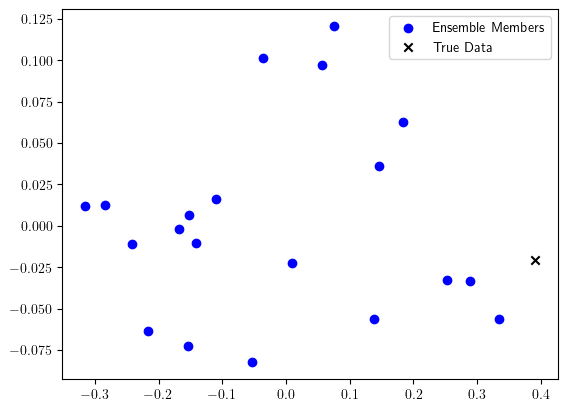

In [19]:
from phate import PHATE

phate = PHATE(n_components=2, n_jobs=4)

embedding = phate.fit_transform(vis_outputs)

plt.scatter(embedding[:-1, 0], embedding[:-1, 1], c='b', label='Ensemble Members')

plt.scatter(embedding[-1, 0], embedding[-1, 1], c='black', marker='x', label='True Data')

plt.legend()
plt.show()